Epoch 10/50, Loss: 0.4065
Epoch 20/50, Loss: 0.4675
Epoch 30/50, Loss: 0.1257
Epoch 40/50, Loss: 0.1137
Epoch 50/50, Loss: 0.0429
Indices of misclassified test images:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


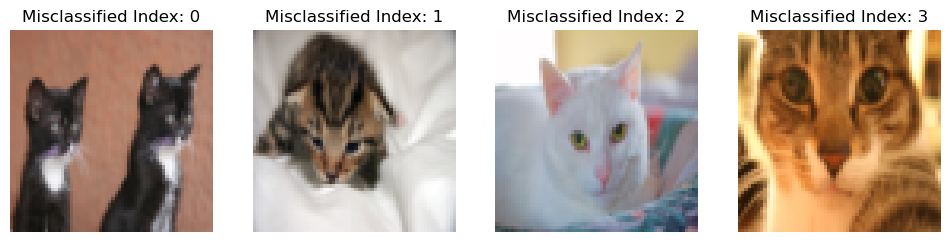

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load data
def load_dataset(train_path, test_path):
    with h5py.File(train_path, "r") as train_data, h5py.File(test_path, "r") as test_data:
        X_train = np.array(train_data["train_set_x"][:])  # Shape (m_train, height, width, channels)
        Y_train = np.array(train_data["train_set_y"][:])  # Shape (m_train,)
        X_test = np.array(test_data["test_set_x"][:])  # Shape (m_test, height, width, channels)
        Y_test = np.array(test_data["test_set_y"][:])  # Shape (m_test,)

    return X_train, Y_train, X_test, Y_test

# Preprocessing
def preprocess_data(X, Y):
    X = X.reshape(X.shape[0], -1) / 255.0  # Flatten and normalize
    Y = Y.reshape(-1, 1)  # Reshape for compatibility
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.long)

# Define the model
class FeedforwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 classes (cat vs non-cat)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training function
def train_model(model, criterion, optimizer, X_train, Y_train, num_epochs=50, batch_size=32):
    for epoch in range(num_epochs):
        model.train()
        perm = torch.randperm(X_train.size(0))
        for i in range(0, X_train.size(0), batch_size):
            indices = perm[i:i+batch_size]
            batch_X, batch_Y = X_train[indices], Y_train[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y.view(-1))
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

# Evaluation function
def evaluate_model(model, X, Y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predictions = torch.max(outputs, 1)
        accuracy = (predictions == Y.view(-1)).float().mean().item()
        incorrect_indices = torch.where(predictions != Y.view(-1))[0].tolist()
    return accuracy, incorrect_indices

# Load dataset
train_path = "/Users/inijjar/Downloads/train_catvnoncat.h5"
test_path = "/Users/inijjar/Downloads/test_catvnoncat.h5"
X_train, Y_train, X_test, Y_test = load_dataset(train_path, test_path)

# Preprocess dataset
X_train, Y_train = preprocess_data(X_train, Y_train)
X_test, Y_test = preprocess_data(X_test, Y_test)

# Initialize model
input_size = X_train.size(1)
model = FeedforwardNN(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
train_model(model, criterion, optimizer, X_train, Y_train, num_epochs=50)

# Perform prediction on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test)
    predictions = (outputs > 0.5).squeeze().int()  # Convert probabilities to binary predictions

# Find misclassified test samples
test_incorrect = torch.where(predictions != Y_test.int())[0].tolist()

print("Indices of misclassified test images:")
print(test_incorrect)

# Visualize 4 of the misclassified images
plt.figure(figsize=(12, 8))

for idx, i in enumerate(test_incorrect[:4]):  # Show only the first 4 misclassified images
    img = X_test[i].detach().cpu().numpy().reshape(64, 64, 3) * 255.0  # Scale back to original range
    plt.subplot(1, 4, idx + 1)
    plt.imshow(img.astype('uint8'))
    plt.title(f"Misclassified Index: {i}")
    plt.axis("off")

plt.show()
